<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/CU/Lab4_Curie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab4 Curie experiment

Evgeny Kolonsky 2025

v0.1.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
def survival_function(x, height, loc, sigma, offset):
    return height * norm.sf(x, loc, sigma) + offset

def weighted_average(values, errors):
  weights = 1 / errors**2
  average  = np.sum(weights * values) / np.sum(weights)
  error_of_average = np.sqrt(1 / np.sum(weights))
  return average, error_of_average

def smooth(signal, window_size=30):
  # Create the kernel for a simple moving average
  # Each element in the window gets a weight of 1/window_size
  kernel = np.ones(window_size) / window_size
  # Perform the convolution
  smoothed_signal = np.convolve(signal, kernel, mode='same')
  return smoothed_signal



# Sample 1_12. Explore data

Load an clean data

In [3]:
#set 12
url = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/set12_sample1/scan_N1.csv'
time_, temp, voltage = np.loadtxt(url, delimiter=',', skiprows=1, usecols=[0, 1, 2], unpack=True)

# skip 1st 10 seconbds
time = time_[time_>10]
temp = temp[time_>10]
voltage = voltage[time_>10]

View graph of $\dot T$ vs $T$, where $T$ - temperature, raw data and smoothed

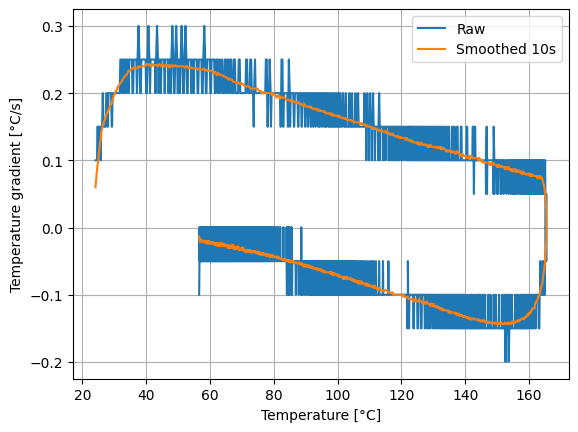

In [4]:
dtemp = np.gradient(temp) / np.gradient(time)

plt.plot(temp, dtemp, label='Raw')

plt.grid()
plt.xlabel('Temperature [°C]')
plt.ylabel('Temperature gradient [°C/s]')

dtemp_smoothed = smooth(dtemp)

plt.plot(temp, dtemp_smoothed, label='Smoothed 10s')
plt.legend()

# Timeline

View temperature change on time axis and divide time by `heating` and `cooling` parts

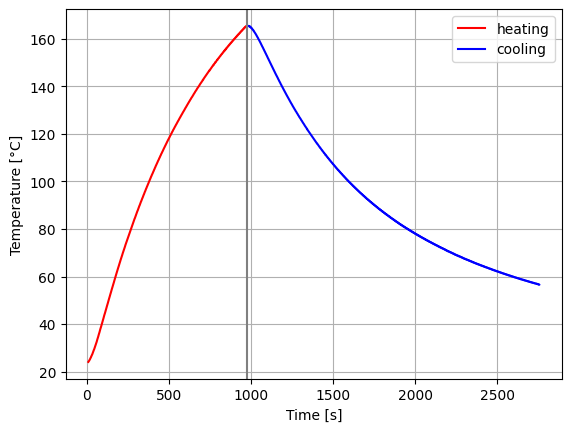

In [5]:
ix = np.argmax(temp)
t0 = time[ix]
temp_max = np.max(temp)

plt.plot(time[time<t0], temp[time<t0], color='red', label='heating')
plt.plot(time[time>t0], temp[time>t0], color='blue', label='cooling')
plt.axvline(t0, color='gray')
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.legend()


## Signal smoothing approach

(-5.285940036474518, 5.360244833074397)

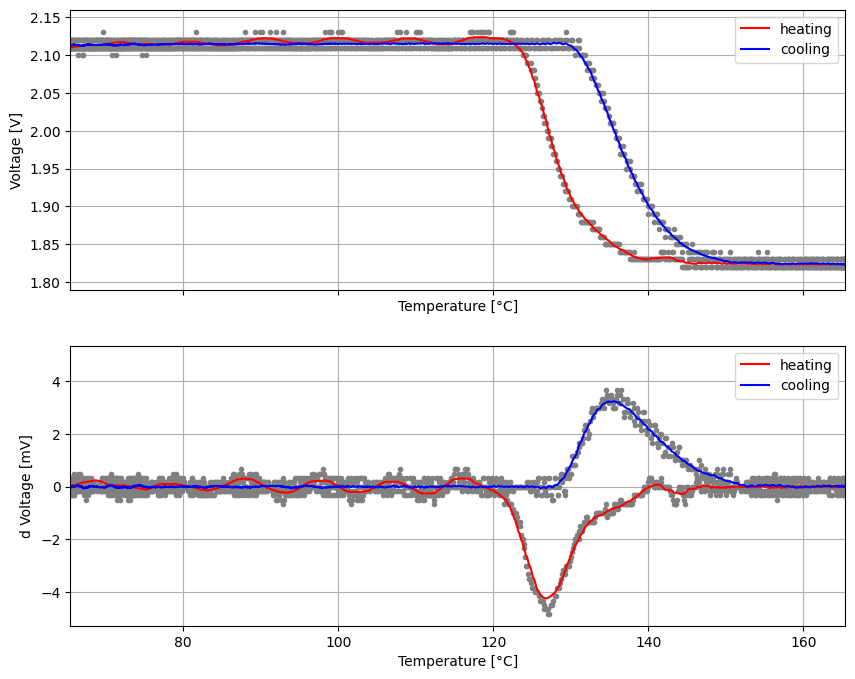

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax[0].plot(temp, voltage, '.', color='gray')
v = smooth(voltage)
ax[0].plot(temp[time<t0], v[time<t0], color='red', label='heating')
ax[0].plot(temp[time>t0], v[time>t0], color='blue', label='cooling')
ax[0].legend()
ax[0].set_xlim(temp_max-130, temp_max)
ax[0].grid()
ax[0].set_xlabel('Temperature [°C]')
ax[0].set_ylabel('Voltage [V]')
ax[0].set_ylim(np.min(voltage)-0.03, np.max(voltage)+0.03)

dv = np.gradient(v) *1e3
dvs = smooth(dv)
ax[1].plot(temp, dv, '.', color='gray')
ax[1].plot(temp[time<t0], dvs[time<t0], color='red', label='heating')
ax[1].plot(temp[time>t0], dvs[time>t0], color='blue', label='cooling')
ax[1].set_xlim(temp_max-100, temp_max)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Temperature [°C]')
ax[1].set_ylabel('d Voltage [mV]')
dv0, dvsigma = np.mean(dvs), np.std(dvs)
ax[1].set_ylim(dv0 -  dvsigma-1, dv0 + dvsigma + 1)




## Statistic approach:

Suggest that Curie point transition is a gaussian process depending on temperature T and fit with survival function
$$
s(x, \mu, \sigma)   = 1 - N\left( \frac{x-\mu}{\sigma} \right)
$$

We look for S(x) solution in from scaled by amplitude and having offset:
$$
 A\cdot s(x, \mu, \sigma) + C
$$

The result of fit interpreted as follows:
the center of normal distribution $\mu$ is the Curie point temperature $T_c$, and width of normal distribution $\sigma$ is it's uncertainty.

Since we have two occurences of Tc, first in heating process, second in cooling process, we can compare them and suggest weighted average.

[  0.29022948 128.23366099   3.48920885   1.8275172 ]
[  0.28759047 137.14662359   4.28885829   1.82696477]
Chi2 reduced (heating): 0.62
Chi2 reduced (cooling): 0.35
Heating fit Tc: 128 ± 3 °C
Cooling fit Tc: 137 ± 4 °C


(np.float64(17.035), np.float64(172.465))

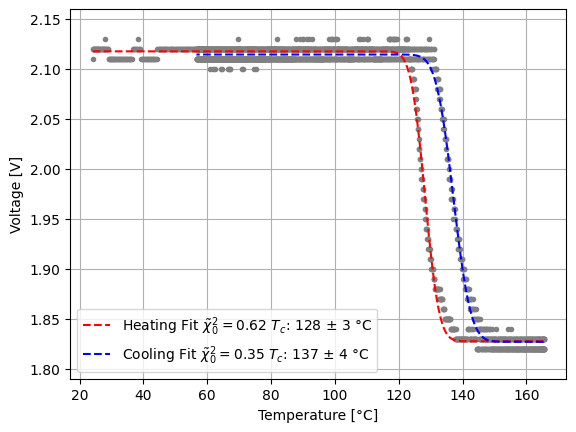

In [7]:
uncertainty = 0.01 # V - artefact from the measurements data, written up to the second digit after comma.
temp_h,  temp_c = temp[time < t0], temp[time > t0]
voltage_h, voltage_c = voltage[time < t0], voltage[time > t0]

plt.plot(temp, voltage, '.', color='gray')
# Fit the heating curve
#initial = [0.6, 250, 20, 1.8]
initial = [0.3, 140, 20, 1.8]
popt_heating, pcov_heating = curve_fit(survival_function, temp_h, voltage_h, p0=initial)
print(popt_heating)
# Fit the cooling curve
popt_cooling, pcov_cooling = curve_fit(survival_function, temp_c, voltage_c, p0=initial)
print(popt_cooling)
# Plot the fitted curves

chi2_observed_h = np.sum(((voltage_h - survival_function(temp_h, *popt_heating)) / uncertainty)**2)
chi2_reduced_h = chi2_observed_h / (len(temp_h) - len(popt_heating))
print(f'Chi2 reduced (heating): {chi2_reduced_h:.2f}')

chi2_observed_c = np.sum(((voltage_c - survival_function(temp_c, *popt_cooling)) / uncertainty)**2)
chi2_reduced_c = chi2_observed_c / (len(temp_c) - len(popt_heating))
print(f'Chi2 reduced (cooling): {chi2_reduced_c:.2f}')

Tc_heating, Tc_heating_sigma = popt_heating[1], popt_heating[2]
Tc_cooling, Tc_cooling_sigma = popt_cooling[1], popt_cooling[2]
print(f'Heating fit Tc: {Tc_heating:.0f} ± {Tc_heating_sigma:.0f} °C')
print(f'Cooling fit Tc: {Tc_cooling:.0f} ± {Tc_cooling_sigma:.0f} °C')

plt.plot(temp[time<t0], survival_function(temp[time<t0], *popt_heating), 'r--',
         label=rf'Heating Fit $\tilde\chi^2_0 = {chi2_reduced_h:.2f}$ $T_c$: {Tc_heating:.0f} ± {Tc_heating_sigma:.0f} °C')
plt.plot(temp[time>t0], survival_function(temp[time>t0], *popt_cooling), 'b--',
         label=rf'Cooling Fit $\tilde\chi^2_0 = {chi2_reduced_c:.2f}$ $T_c$: {Tc_cooling:.0f} ± {Tc_cooling_sigma:.0f} °C')
plt.legend()
plt.grid()
plt.xlabel('Temperature [°C]')
plt.ylabel('Voltage [V]')
plt.ylim(np.min(voltage)-0.03, np.max(voltage)+0.03)
plt.xlim()

# since we have a lot of samples to analyze, nice to have a pipeline function analyzing data and extracting $Tc$

In [8]:
def analyze(url):
  time_, temp, voltage = np.loadtxt(url, delimiter=',', skiprows=1, usecols=[0, 1, 2], unpack=True)

  # skip 1st 10 seconbds
  time = time_[time_>10]
  temp = temp[time_>10]
  voltage = voltage[time_>10]

  # timeline
  ix = np.argmax(temp)
  t0 = time[ix]
  temp_max = np.max(temp)

  uncertainty = 0.01 # V
  temp_h,  temp_c = temp[time < t0], temp[time > t0]
  voltage_h, voltage_c = voltage[time < t0], voltage[time > t0]

  plt.plot(temp, voltage, '.', color='gray')
  # Fit the heating curve

  height = np.max(voltage) - np.min(voltage)
  offset = np.min(voltage)
  sigma = 10
  loc = temp_max - sigma
  initial = [height, loc, sigma, offset]

  popt_heating, pcov_heating = curve_fit(survival_function, temp_h, voltage_h, p0=initial)
  #print(popt_heating)
  # Fit the cooling curve
  popt_cooling, pcov_cooling = curve_fit(survival_function, temp_c, voltage_c, p0=initial)
  #print(popt_cooling)
  # Plot the fitted curves

  chi2_observed_h = np.sum(((voltage_h - survival_function(temp_h, *popt_heating)) / uncertainty)**2)
  chi2_reduced_h = chi2_observed_h / (len(temp_h) - len(popt_heating))
  #print(f'Chi2 reduced (heating): {chi2_reduced_h:.2f}')

  chi2_observed_c = np.sum(((voltage_c - survival_function(temp_c, *popt_cooling)) / uncertainty)**2)
  chi2_reduced_c = chi2_observed_c / (len(temp_c) - len(popt_heating))
  #print(f'Chi2 reduced (cooling): {chi2_reduced_c:.2f}')

  Tc_heating, Tc_heating_sigma = popt_heating[1], popt_heating[2]
  Tc_cooling, Tc_cooling_sigma = popt_cooling[1], popt_cooling[2]
  #print(f'Heating fit Tc: {Tc_heating:.0f} ± {Tc_heating_sigma:.0f} °C')
  #print(f'Cooling fit Tc: {Tc_cooling:.0f} ± {Tc_cooling_sigma:.0f} °C')

  plt.plot(temp[time<t0], survival_function(temp[time<t0], *popt_heating), 'r--',
          label=rf'Heating Fit $\tilde\chi^2_0 = {chi2_reduced_h:.2f}$ $T_c$: {Tc_heating:.0f} ± {Tc_heating_sigma:.0f} °C')
  plt.plot(temp[time>t0], survival_function(temp[time>t0], *popt_cooling), 'b--',
          label=rf'Cooling Fit $\tilde\chi^2_0 = {chi2_reduced_c:.2f}$ $T_c$: {Tc_cooling:.0f} ± {Tc_cooling_sigma:.0f} °C')
  plt.legend()
  plt.grid()
  plt.xlabel('Temperature [°C]')
  plt.ylabel('Voltage [V]')
  plt.ylim(np.min(voltage)-0.03, np.max(voltage)+0.03)
  plt.show()
  values = np.array([Tc_heating, Tc_cooling])
  errors = np.array([Tc_heating_sigma, Tc_cooling_sigma])
  Tc, Tc_error = weighted_average(values, errors)

  return Tc, Tc_error


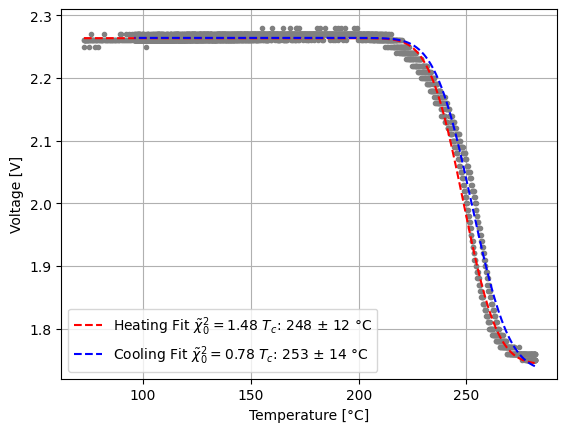

04 Weighted Tc: 250 ± 9 °C


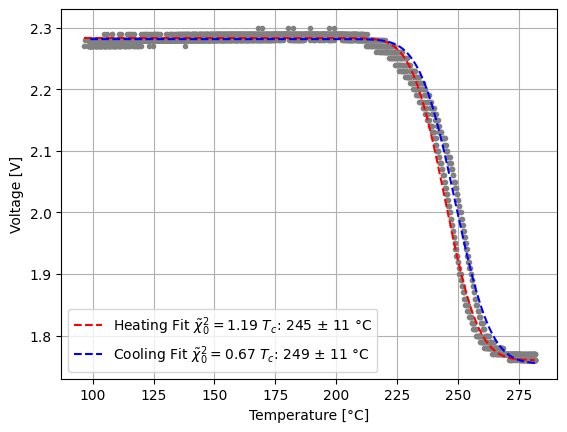

06 Weighted Tc: 247 ± 8 °C


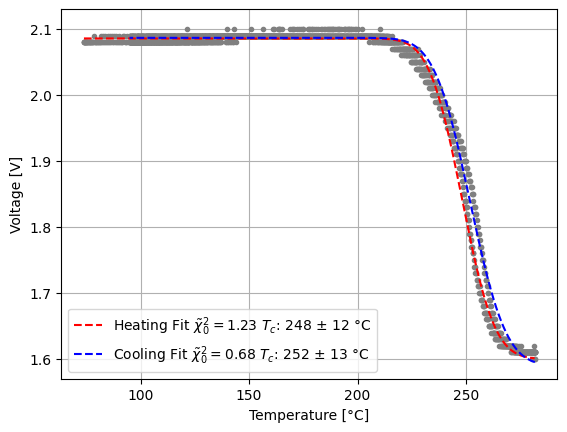

09 Weighted Tc: 250 ± 9 °C


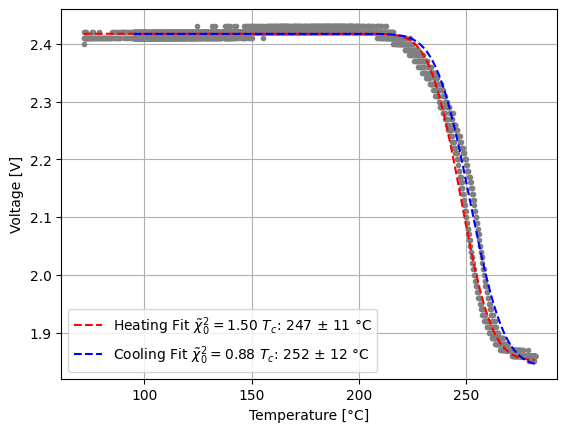

10 Weighted Tc: 249 ± 8 °C


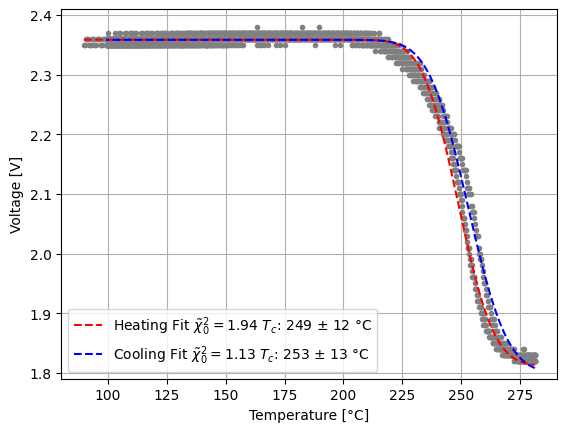

12 Weighted Tc: 251 ± 9 °C


In [9]:
for sample in ['04', '06', '09', '10', '12']:
  url = f'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/sample2/test2/{sample}/{sample}%2050%20V%20Heater.csv'
  Tc, Tc_error = analyze(url)
  print(f'{sample} Weighted Tc: {Tc:.0f} ± {Tc_error:.0f} °C')

# Sample 1_12

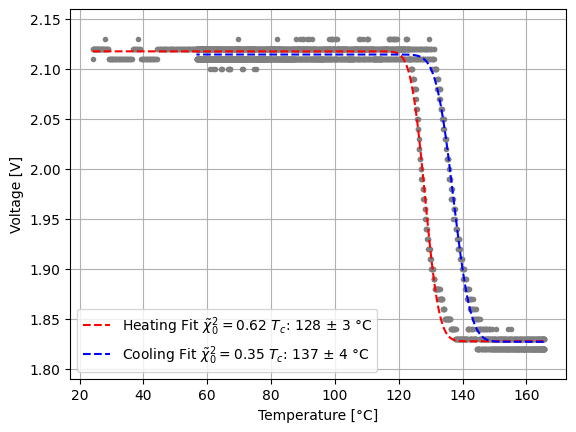

Weighted Tc: 132 ± 3 °C


In [10]:
url = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/set12_sample1/scan_N1.csv'
Tc, Tc_error = analyze(url)
print(f'Weighted Tc: {Tc:.0f} ± {Tc_error:.0f} °C')

In this sample we have statistically different results for $T_c$ in heating and in cooling process, so we should not trust error of weighted average  $T_c$.